In [1]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import os
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/device:GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
except RuntimeError as e:
  print(e)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0


In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
path = '/content/drive/My Drive/pictures'

In [6]:
import pathlib
data = pathlib.Path('/content/drive/My Drive/pictures/Great_Egret') 
count = len(list(data.glob('*.jpg')))
count

575

In [7]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(path)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.05)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/My Drive/pictures
Found 305 images belonging to 16 classes.
Found 5920 images belonging to 16 classes.


In [8]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 16)
['American_Crow' 'American_Kestrel' 'American_Robin' 'Blue_Jay'
 'Carolina_Chickadee' 'Carolina_Wren' 'Common_Grackle' 'Eastern_Phoebe'
 'European_Starling' 'Great_Blue_Heron' 'Great_Egret' 'Northern_Flicker'
 'Northern_Mockingbird' 'Rock_Pigeon' 'Snowy_Egret' 'Tufted_Titmouse']


In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0

In [14]:
# Import checkpoint dependencies
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
# os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "/content/drive/My Drive/checkpoints/weights.{epoch:02d}.h5"

#saved_model_path = "/content/drive/My Drive/checkpoints/weights.{epoch:02d}.hdf5"  # or you can simply use 'my_mode.h5'
#model.save(saved_model_path)

In [17]:
# Create a callback that saves the model every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=False,
    save_freq='epoch')

In [18]:
fit_model = model.fit(train_generator, validation_data = valid_generator,epochs=30, callbacks=[cp_callback])

Epoch 1/30
185/185 [==============================] - ETA: 0s - loss: 0.0954 - acc: 0.9662
Epoch 1: saving model to /content/drive/My Drive/checkpoints/weights.01.h5
185/185 [==============================] - 732s 4s/step - loss: 0.0954 - acc: 0.9662 - val_loss: 2.5720 - val_acc: 0.5607
Epoch 2/30
185/185 [==============================] - ETA: 0s - loss: 0.1137 - acc: 0.9610
Epoch 2: saving model to /content/drive/My Drive/checkpoints/weights.02.h5
185/185 [==============================] - 731s 4s/step - loss: 0.1137 - acc: 0.9610 - val_loss: 3.0060 - val_acc: 0.5016
Epoch 3/30
185/185 [==============================] - ETA: 0s - loss: 0.1057 - acc: 0.9650
Epoch 3: saving model to /content/drive/My Drive/checkpoints/weights.03.h5
185/185 [==============================] - 723s 4s/step - loss: 0.1057 - acc: 0.9650 - val_loss: 2.5076 - val_acc: 0.5902
Epoch 4/30
185/185 [==============================] - ETA: 0s - loss: 0.0861 - acc: 0.9718
Epoch 4: saving model to /content/drive/My Dr

UnknownError: ignored

In [19]:
# Evaluate the model using the validation data
model_loss, model_accuracy = model.evaluate(valid_generator)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

10/10 [==============================] - 11s 1s/step - loss: 2.9679 - acc: 0.5246
Loss: 2.9679315090179443, Accuracy: 0.5245901346206665


In [20]:
# reload earlier model due to error in epoch 19
saved_model_path = "/content/drive/My Drive/checkpoints/weights.04.h5" # or you can simply use 'my_mode.h5'
model.save(saved_model_path) #save your model 

# to reload your model 
model = keras.models.load_model(saved_model_path)

In [21]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [22]:
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

1/1 [==============================] - 2s 2s/step
Prediction results for the first elements


,American_Crow,American_Kestrel,American_Robin,Blue_Jay,Carolina_Chickadee,Carolina_Wren,Common_Grackle,Eastern_Phoebe,European_Starling,Great_Blue_Heron,Great_Egret,Northern_Flicker,Northern_Mockingbird,Rock_Pigeon,Snowy_Egret,Tufted_Titmouse
0,3.534179e-04,2.630375e-09,1.514714e-07,1.302770e-05,3.209198e-05,1.240870e-02,2.407070e-01,3.972262e-04,7.325179e-01,3.914196e-04,1.295761e-02,1.467686e-05,4.039815e-05,9.178794e-05,2.023443e-05,5.430833e-05
1,4.500262e-04,1.984250e-04,9.590368e-07,3.832850e-07,6.458338e-08,1.742018e-09,6.054118e-06,2.580135e-08,8.689201e-06,9.890705e-01,2.659062e-04,1.951232e-05,8.084724e-03,1.844296e-03,4.811120e-06,4.551110e-05
2,5.561587e-07,8.948637e-08,9.778969e-06,2.170113e-07,1.587797e-04,2.072369e-01,2.745102e-05,7.923471e-01,5.277112e-05,8.764954e-07,1.906208e-05,1.968521e-07,1.229878e-04,1.076974e-07,7.764082e-07,2.235320e-05
3,9.072245e-06,6.421269e-10,1.767578e-11,6.922606e-09,9.843001e-10,4.701923e-07,9.999787e-01,9.696687e-06,2.436680e-07,1.220390e-07,2.159168e-07,1.955706e-08,5.234925e-07,1.846243e-08,4.030732e-10,7.192657e-07
4,6.283137e-09,7.892199e-07,1.009447e-09,3.083301e-10,1.030428e-09,5.473397e-09,6.435333e-11,8.102586e-10,1.915938e-07,2.303525e-08,1.547989e-08,7.764499e-04,9.992226e-01,3.512977e-09,1.630316e-11,2.266302e-09


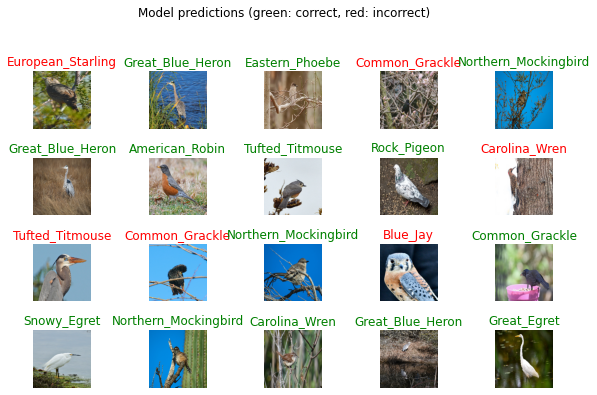

In [23]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
tf.saved_model.save(model, "path/to/saved_model")